## ELETTRA-05: ID linear optics distortion

In [1]:
# In this example effects of an ID (APPLE-II device (40*100mm) represented by a linear 4x4 symplectic matrix) are presented
# ID is inserted replacing a selected marker as a thin insertion

# The following effects on the linear optics are investigated:

# -- Tune shifts
# -- Dispersion
# -- Beta beating
# -- Coupling (minimal tune distance)

# ID is modeled as a linear element
# Corresponding transport matrix is M = exp(S A) exp(dp S B)

# Additionaly, effects of LPU are also presented (98*46mm)

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice lattice

ring.splice()

# Describe

ring.describe

{'BPM': 168, 'Drift': 708, 'Dipole': 156, 'Quadrupole': 360, 'Marker': 12}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
# Define ID model (single kick)
# Note, only the flattened triangular part of the A and B matrices is passed


A = torch.tensor([[-0.033664857671742154, 0.0, 0.0, 0.0], 
                  [0.0, 0.0, 0.0, 0.0], 
                  [0.0, 0.0, 0.0585058830814459, 0.0], 
                  [0.0, 0.0, 0.0, 0.0]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist())

In [12]:
# Insert ID into the existing lattice
# This will replace the target marker

ring.flatten()
ring.insert(ID, 'MLL_S01', position=0.0)
ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [13]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [14]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(ring, orbit, [], limit=1)

In [15]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

In [16]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

In [17]:
# Compute coupling

c_id = coupling(ring, [])

In [18]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0247, dtype=torch.float64)
tensor(-0.0075, dtype=torch.float64)


In [19]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


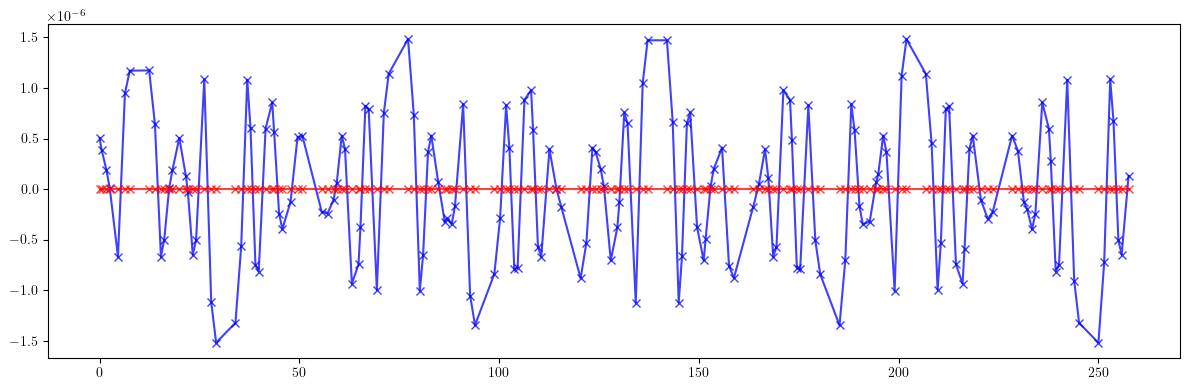

In [20]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

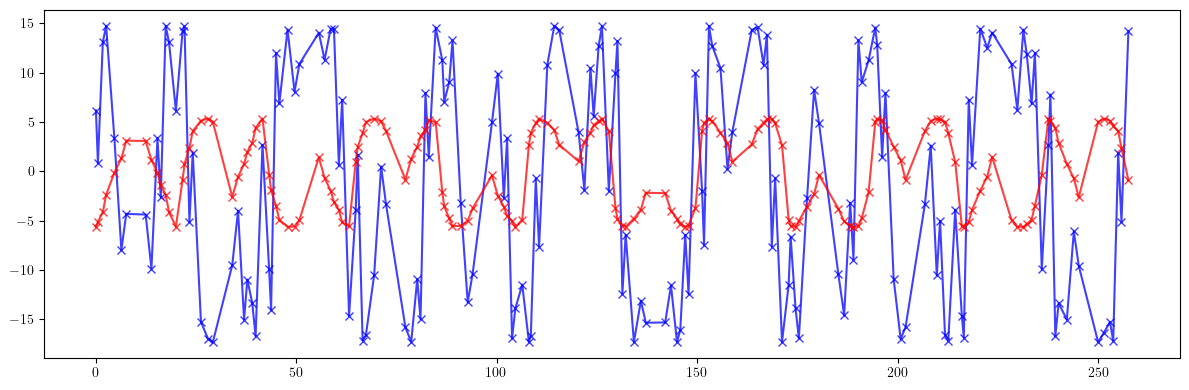

tensor(11.3919, dtype=torch.float64)
tensor(4.0971, dtype=torch.float64)


In [21]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

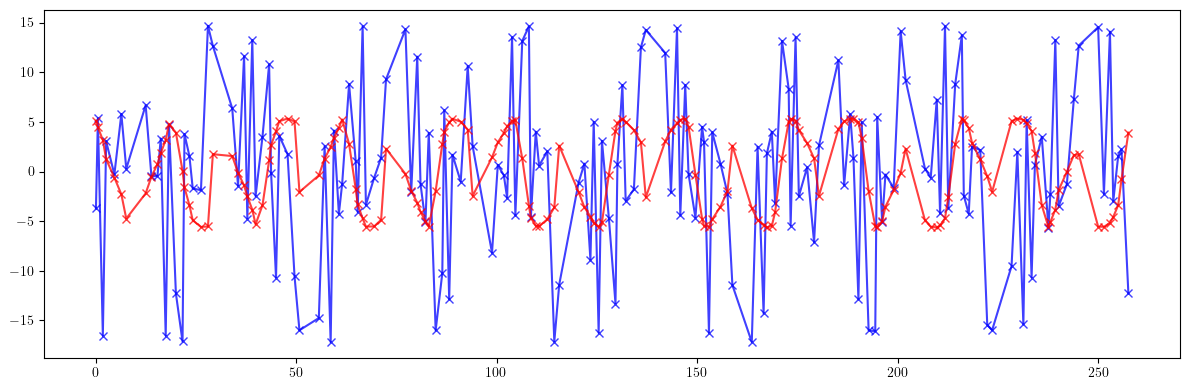

tensor(8.6388, dtype=torch.float64)
tensor(3.9969, dtype=torch.float64)


In [22]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [23]:
# Define ID model (one kick for each period)
# Note, only the flattened triangular part of the A and B matrices is passed


A = torch.tensor([[-0.034441907232402175, 0.0, 0.0, 0.0],
                  [0.0, -0.04458009513208418, 0.0, 0.0],
                  [0.0, 0.0, 0.056279356423643276, 0.0], 
                  [0.0, 0.0, 0.0, 0.08037110220505986]], dtype=dtype)


ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist())

In [24]:
# Replace ID

ring.flatten()
ring.replace("ID", ID)
ring.splice()
ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [25]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [26]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(ring, orbit, [], limit=1)

In [27]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

In [28]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

In [29]:
# Compute coupling

c_id = coupling(ring, [])

In [30]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0257, dtype=torch.float64)
tensor(-0.0112, dtype=torch.float64)


In [31]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


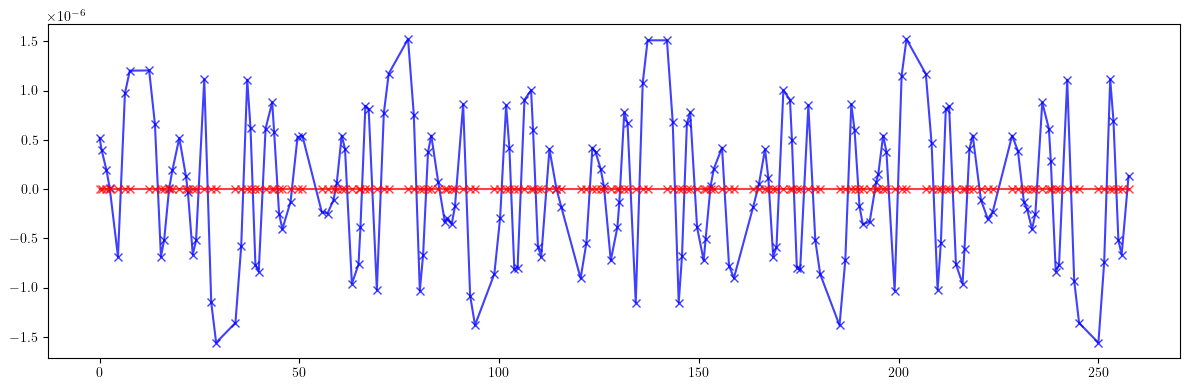

In [32]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

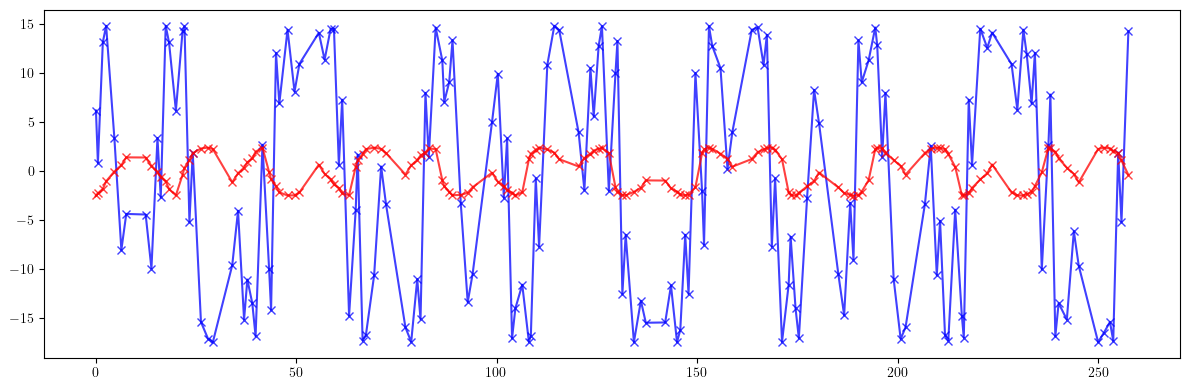

tensor(11.4721, dtype=torch.float64)
tensor(1.8233, dtype=torch.float64)


In [33]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

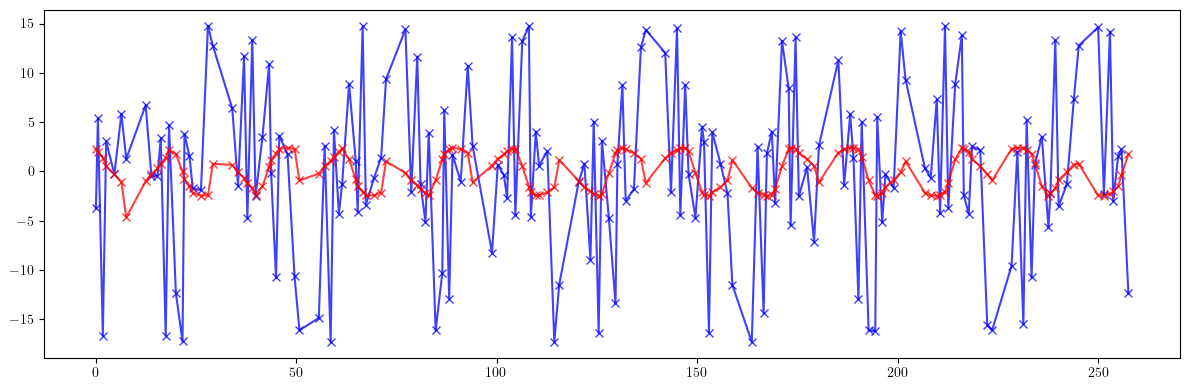

tensor(8.6991, dtype=torch.float64)
tensor(1.8072, dtype=torch.float64)


In [34]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [35]:
# Define ID model (full model with leading order chormatic effects)
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [36]:
# Replace ID

ring.flatten()
ring.replace("ID", ID)
ring.splice()
ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [37]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [38]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(ring, orbit, [], limit=1)

In [39]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

In [40]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

In [41]:
# Compute coupling

c_id = coupling(ring, [])

In [42]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0260, dtype=torch.float64)
tensor(-0.0114, dtype=torch.float64)


In [43]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


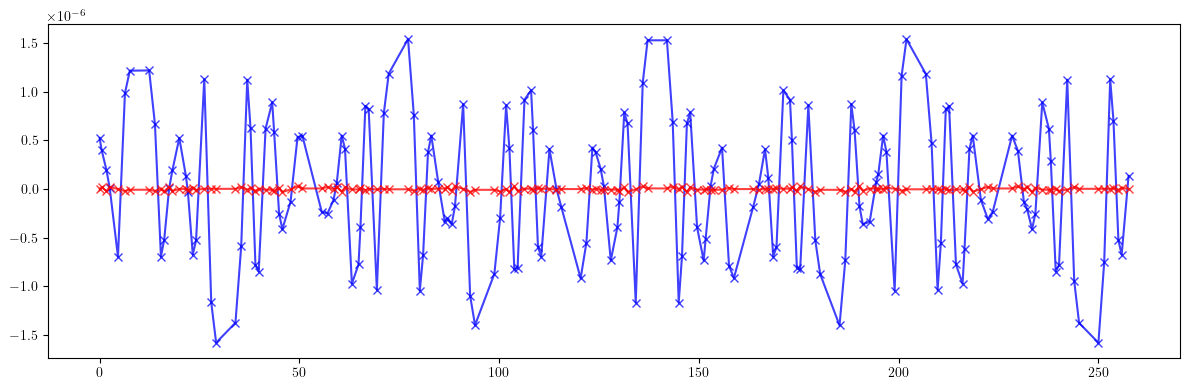

In [44]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

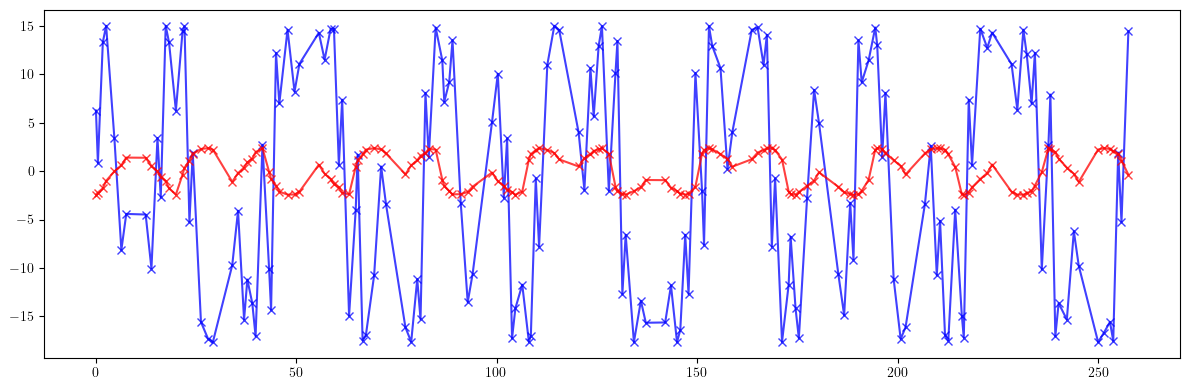

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)


In [45]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

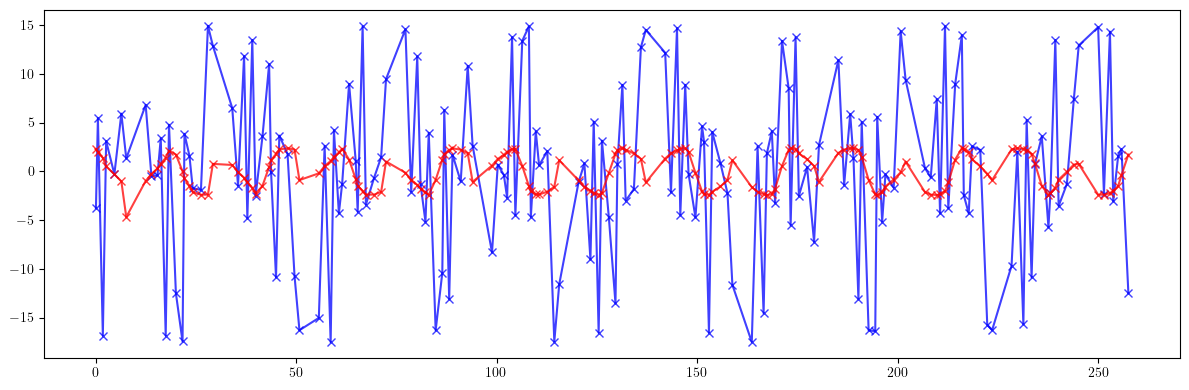

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)


In [46]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

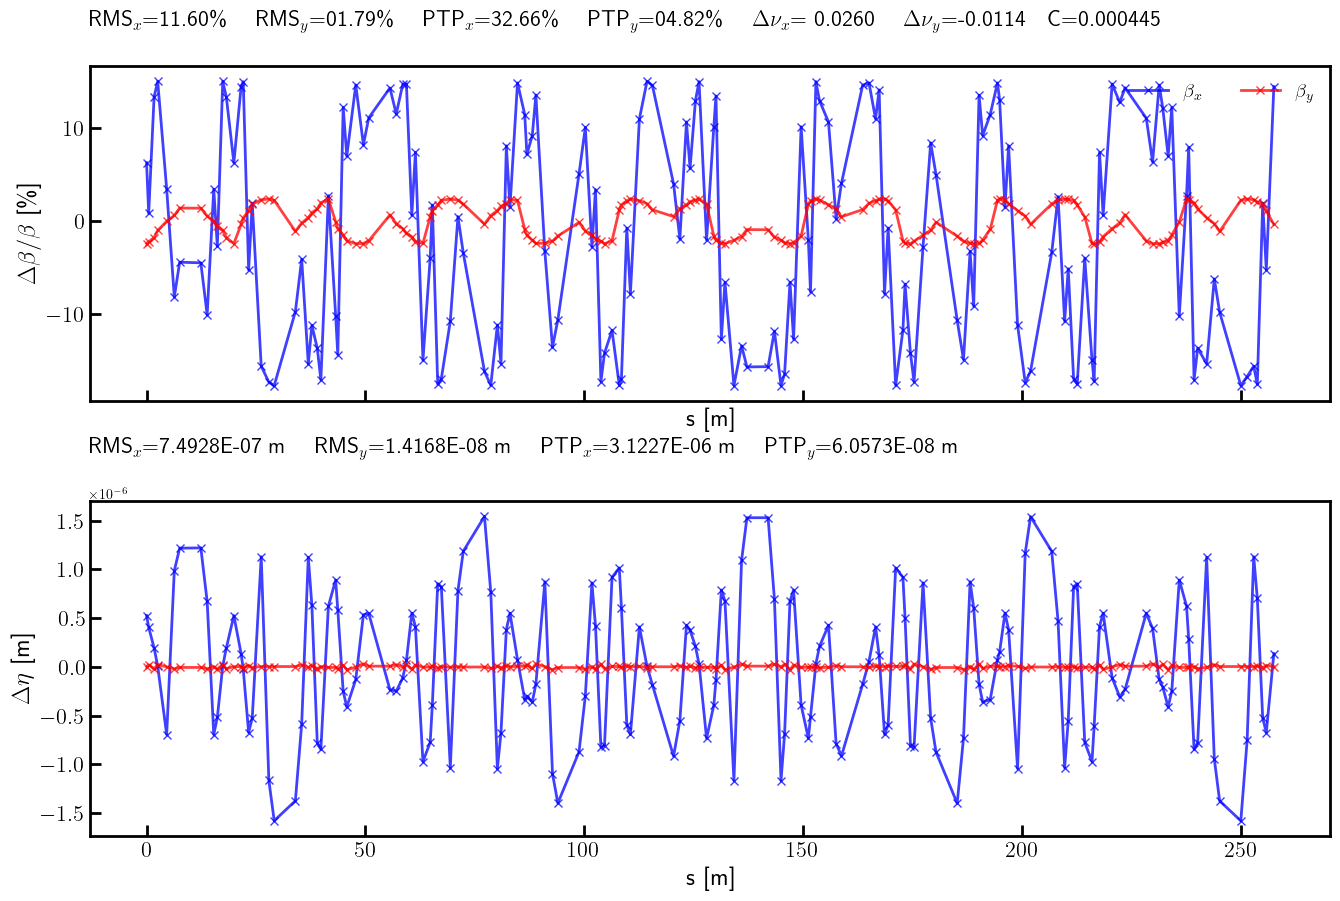

In [47]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_id)    / bx
by_ref_bb = 100.0*(by - by_id)    / by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()

etax_ref = etaqx - etaqx_id
etay_ref = etaqy - etaqy_id

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'$\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'$\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_id)}{(nux - nux_id).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_id)}{(nuy - nuy_id).abs().item():.4f}'
    rf'\quad C={c_id.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'$\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'$\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [48]:
# Define ID model (LPU)

A = torch.tensor([[-0.00012383337794002073, -4.660270490330217E-11, 6.376863691496814E-10, 2.7230065924765254E-9], 
                  [-4.660394652563561E-11, -0.00023205060950586665, -1.3479277794464672E-9, -2.355844533297301E-9], 
                  [6.376863692762265E-10, -1.347927657735391E-9, 0.03660488622324795, 5.772998189350976E-9], 
                  [2.7230065927230765E-9, -2.3558445782246365E-9, 5.772998640180359E-9, 0.06475766873116935]], dtype=dtype)

B = torch.tensor([[0.00012378599381951955, -1.6869692601073327E-7, 7.640630142947167E-8, -2.0548228907169046E-7], 
                  [-1.6869692601073327E-7, 0.0006954279711404285, 1.3864566360308503E-7, -5.549940163648357E-7], 
                  [7.640630142947167E-8, 1.3864566360308503E-7, -0.034632609324692906, 0.0024749659452940626], 
                  [-2.0548228907169046E-7, -5.549940163648357E-7, 0.0024749659452940626, -0.19648005917364772]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [49]:
# Replace ID

ring.flatten()
ring.replace("ID", ID)
ring.splice()
ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [50]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [51]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(ring, orbit, [], limit=1)

In [52]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

In [53]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

In [54]:
# Compute coupling

c_id = coupling(ring, [])

In [55]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(9.4733e-05, dtype=torch.float64)
tensor(-0.0079, dtype=torch.float64)


In [56]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(1.1869e-09, dtype=torch.float64)


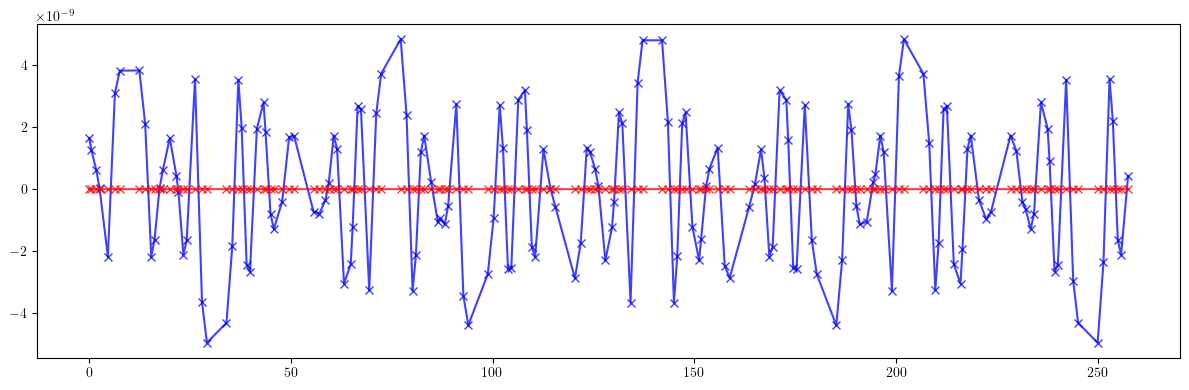

In [57]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

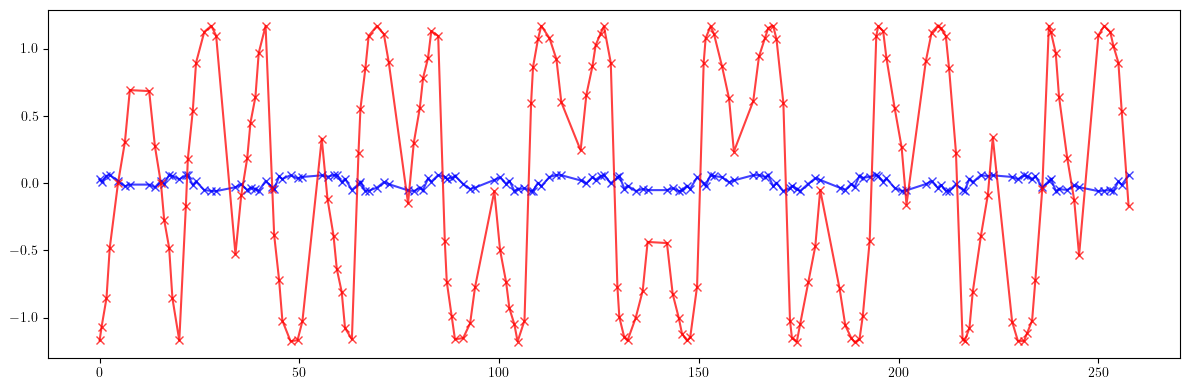

tensor(0.0423, dtype=torch.float64)
tensor(0.8755, dtype=torch.float64)


In [58]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

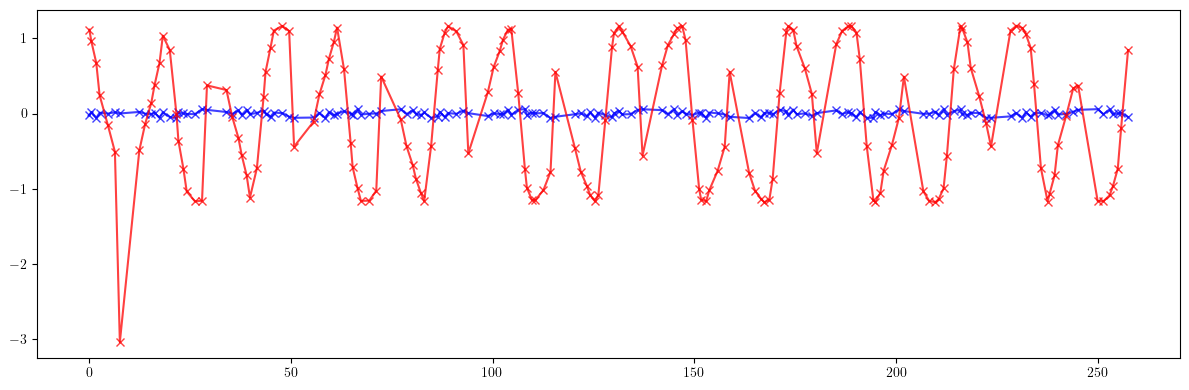

tensor(0.0323, dtype=torch.float64)
tensor(0.8822, dtype=torch.float64)


In [59]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

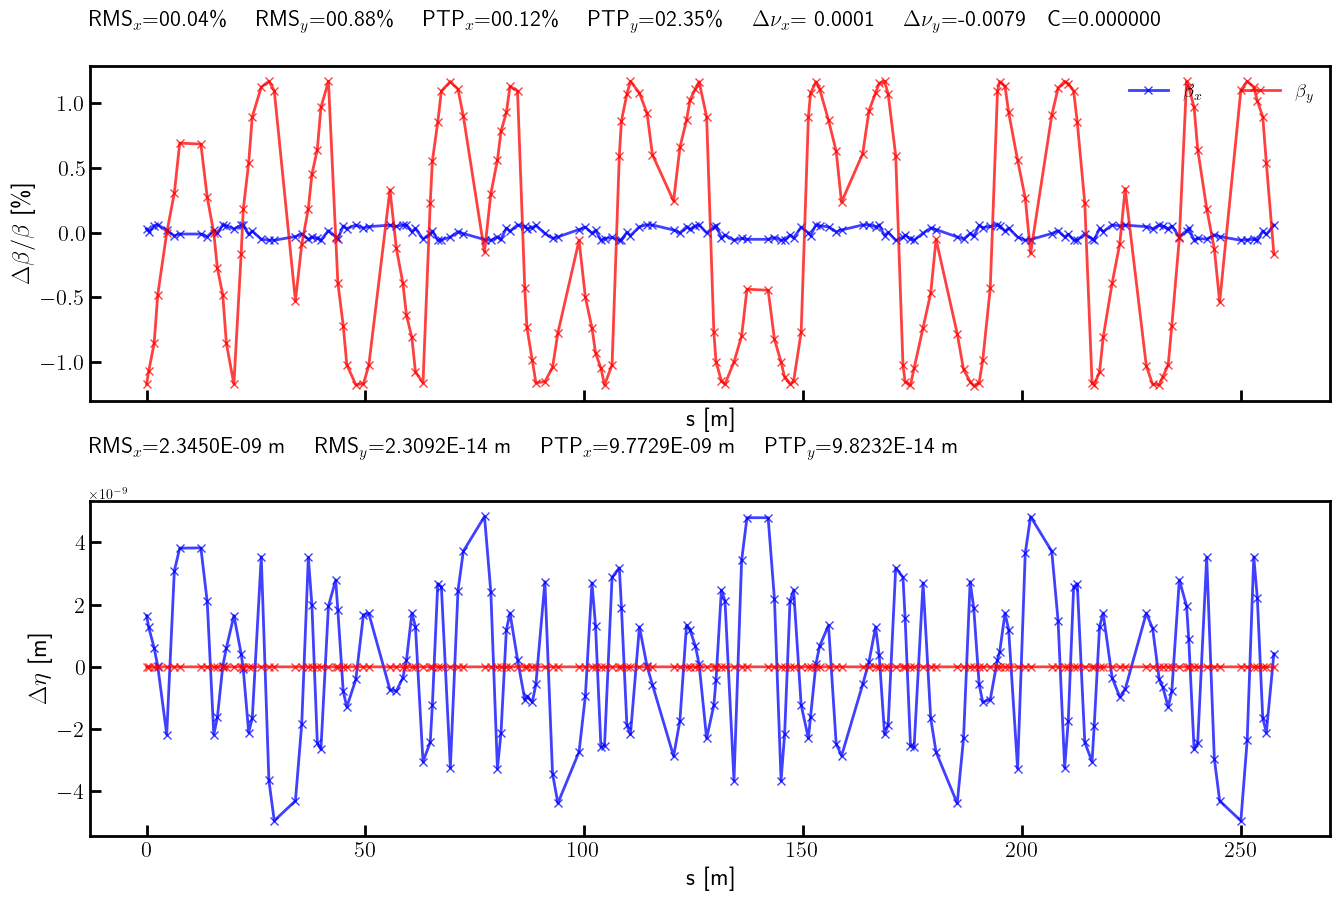

In [60]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_id)    / bx
by_ref_bb = 100.0*(by - by_id)    / by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()

etax_ref = etaqx - etaqx_id
etay_ref = etaqy - etaqy_id

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'$\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'$\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_id)}{(nux - nux_id).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_id)}{(nuy - nuy_id).abs().item():.4f}'
    rf'\quad C={c_id.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'$\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'$\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()